<a href="https://colab.research.google.com/github/RosaliaGimenezBDS/M9_Reto_01/blob/main/Reto_1_M09_Notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Máster en Behavioral Data Science**
## **Instituto de Formación Continua (IL3) - Universitat de Barcelona**
## **Módulo 9: Aprendizaje Profundo - Reto 1** - (Notebook 1/5)
Autores: **Meysam Madadi** & **Julio C. S. Jacques Junior**

---

# **Reto 1:** Reconocimiento automático de edad aparente a partir de imágenes, con análisis de sesgo asociado.

Intentaremos **predecir la edad aparente de personas a partir de datos de imágenes** (tarea de regresión), **utilizando un conjunto de datos desbalanceado** con respecto a diferentes atributos (etiquetas de edad y metadatos, como el origen étnico y la expresión facial).


# **Objetivo general**

- Practicar y compreender diferentes conceptos de aprendizaje profundo de forma incremental.
- Analyzar diferentes estrategias para **mejorar la precisión** de nuestro modelo **mientras intentamos mitigar algunos sesgos** (p.ej., de edad, de género, etc), utilizando una métrica que hemos definido para nuestro problema.
- Basado en los experimentos, ser capaz de **proporcionar un análisis sólido de los resultados**.

# **Los objetivos de este Jupyter notebook**
- Descargar y formatear los datos;
- Visualizar las distribuciones de datos;
- Construir un modelo CNN.

# **Requisitos previos y notas importantes**

- Colab nos proporciona **recursos de GPU limitados** para entrenar nuestros modelos. Podéis consultar las instrucciones de uso de las GPUs [aquí](https://research.google.com/colaboratory/faq.html#gpu-availability).
- El código os pedirá permiso para acceder a vuestro Google Drive y guardar los datos preprocesados y los modelos entrenados, ya que se utilizarán en otros *Jupyter notebooks* relacionados con el Reto 1. **Necesitaréis tener aproximadamente 4,5 GB disponibles en vuestro Google Drive para esto.**
 - Alternativamente, podríais guardar los datos y modelos en Colab y descargarlos cuando hayáis terminado. En este caso, necesitaríais descargarlos/cargarlos manualmente a través de Colab. Podéis utilizar la interfaz en el lado izquierdo de Colab para descargar/cargar archivos desde/hacia Colab. En este caso, también necesitaríais adaptar el código para guardar/cargar los datos hacia/desde el entorno de Colab (y no desde vuestro Google Drive). Tened en cuenta que los datos y modelos que subimos a Colab se pierden cuando nos desconectamos.

---

## Comprobando la versión de tensorflow

In [1]:
# Este código fue probado en tensorflow 2.15.0

!pip install tensorflow==2.15.0
import tensorflow as tf
print(tf.__version__)




2.15.0


# Descargando y descomprimiendo el conjunto de datos [Appa-Real Age Dataset](http://chalearnlap.cvc.uab.es/challenge/13/track/13/description/)

- Las imágenes RGB originales se encuentran en el rango de [0, 255] y las etiquetas están en el rango de ~0,9 a ~90 (edad). Como veréis, escalaremos algunos valores para que estén en el rango de [0,1] durante el entrenamiento y eventualmente escalaremos el valor predicho al rango de edad (durante la evaluación, usando un factor de normalización predefinido) para hacer la interpretación de los resultados más sencilla.
- Los datos están divididos en conjuntos de **entrenamiento**, **validación** y **prueba**.
- Se proporciona **metadatos**:
  - **gender**: male / female
  - **ethnicity**: asian / afroamerican / caucasian
  - **facial expression**: neutral / slightlyhappy / happy / other


In [2]:
# downloading the data
!wget https://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r1/app_data.zip

# decompressing the data
from zipfile import ZipFile

with ZipFile('app_data.zip','r') as zip:
   zip.extractall()
   print('Data decompressed successfully')

# removing the .zip file after extraction to clean space
!rm app_data.zip

--2024-09-08 18:53:08--  https://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r1/app_data.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 799021037 (762M) [application/zip]
Saving to: ‘app_data.zip’

app_data.zip        100%[===================>] 762.00M  8.42MB/s    in 2m 1s   

2024-09-08 18:55:10 (6.30 MB/s) - ‘app_data.zip’ saved [799021037/799021037]

Data decompressed successfully


# Cargando los datos de entrenamiento, validación y prueba, y escalando las etiquetas a [0,...,1]
- X_train, X_valid, X_test = **Imágenes** de caras
- Y_train, Y_valid, Y_test = **Etiqueta** (edad)
- M_train, M_valid, M_test = **Metadatos** (gender, ethnicicy, facial expression)


In [3]:
import numpy as np

# loading the train data
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# loading the test data
X_test = np.load('./data/data_test.npy')
Y_test = np.load('./data/labels_test.npy')
M_test = np.load('./data/meta_data_test.npy')

# labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100
Y_test  = Y_test/100

print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)
print('----')
print('Test data size and shape', X_test.shape)
print('Test labels size and shape', Y_test.shape)
print('Test metadata size and shape', M_test.shape)

Train data size and shape (4065, 224, 224, 3)
Train labels size and shape (4065,)
Train metadata size and shape (4065, 3)
----
Valid data size and shape (1482, 224, 224, 3)
Valid labels size and shape (1482,)
Valid metadata size and shape (1482, 3)
----
Test data size and shape (1978, 224, 224, 3)
Test labels size and shape (1978,)
Test metadata size and shape (1978, 3)


# Creando un subconjunto del conjunto de datos original

Reduciremos el tamaño de la base de datos para evitar cualquier problema de memoria causado por las limitaciones de Colab. Tened en cuenta que este paso se evitaría en caso de que tuviéramos suficientes recursos computacionales.


In [4]:
# randomly selecting 3k samples of the original train set for training
# fixing the random generator seed to generate the same set everytime
np.random.seed(0)
idx = np.random.choice(X_train.shape[0], 3000)
X_train = X_train[idx,:,:,:]
Y_train = Y_train[idx]
M_train = M_train[idx,:]

# randomly selecting 1k samples of the original validation set for validation
idx = np.random.choice(X_valid.shape[0], 1000)
X_valid = X_valid[idx,:,:,:]
Y_valid = Y_valid[idx]
M_valid = M_valid[idx,:]

# randomly selecting 1k samples of the original test set for testing
idx = np.random.choice(X_test.shape[0], 1000)
X_test = X_test[idx,:,:,:]
Y_test = Y_test[idx]
M_test = M_test[idx,:]

print('Reduced Train data size and shape', X_train.shape)
print('Reduced Train labels size and shape', Y_train.shape)
print('Reduced Train metadata size and shape', M_train.shape)
print('----')
print('Reduced Valid data size and shape', X_valid.shape)
print('Reduced Valid labels size and shape', Y_valid.shape)
print('Reduced Valid metadata size and shape', M_valid.shape)
print('----')
print('Reduced Test data size and shape', X_test.shape)
print('Reduced Test labels size and shape', Y_test.shape)
print('Reduced Test metadata size and shape', M_test.shape)

Reduced Train data size and shape (3000, 224, 224, 3)
Reduced Train labels size and shape (3000,)
Reduced Train metadata size and shape (3000, 3)
----
Reduced Valid data size and shape (1000, 224, 224, 3)
Reduced Valid labels size and shape (1000,)
Reduced Valid metadata size and shape (1000, 3)
----
Reduced Test data size and shape (1000, 224, 224, 3)
Reduced Test labels size and shape (1000,)
Reduced Test metadata size and shape (1000, 3)


# Visualizando algunas muestras de entrenamiento

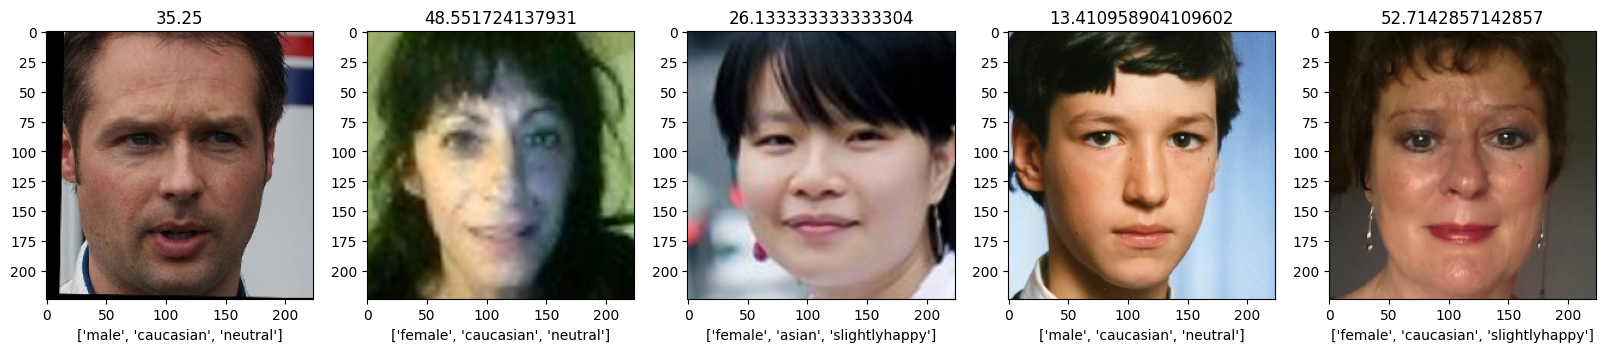

In [5]:
import cv2
import random
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axes):
    idx = random.randint(0, len(X_train))
    ax.imshow(cv2.cvtColor(X_train[idx,:,:,:], cv2.COLOR_BGR2RGB))
    # Note we multiply the normalized age labels by 100 to show the original age values on top of each sample.
    ax.set_title(Y_train[idx]*100)
    ax.set(xlabel=[M_train[idx][0],M_train[idx][1],M_train[idx][2]])

# Visualizando la distribución por edades de los datos de entrenamiento

(0.0, 100.0)

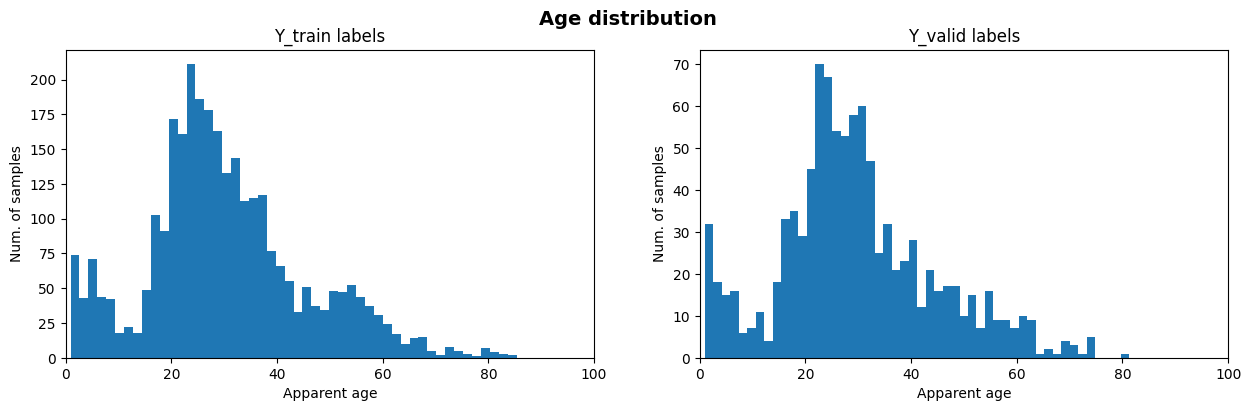

In [6]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Age distribution', fontsize=14, fontweight='bold')

# labels are multiplied by 100 to show the original values
ax1.hist(Y_train*100, bins = 50)
ax1.set_title('Y_train labels')
ax1.set(xlabel='Apparent age', ylabel='Num. of samples')
ax1.set_xlim([0, 100])

ax2.hist(Y_valid*100, bins = 50)
ax2.set_title('Y_valid labels')
ax2.set(xlabel='Apparent age', ylabel='Num. of samples')
ax2.set_xlim([0, 100])

# Visualizando las distribuciones de metadatos (datos de entrenamiento)

(array([1301.,    0.,    0., 1027.,    0.,    0.,  539.,    0.,    0.,
         133.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

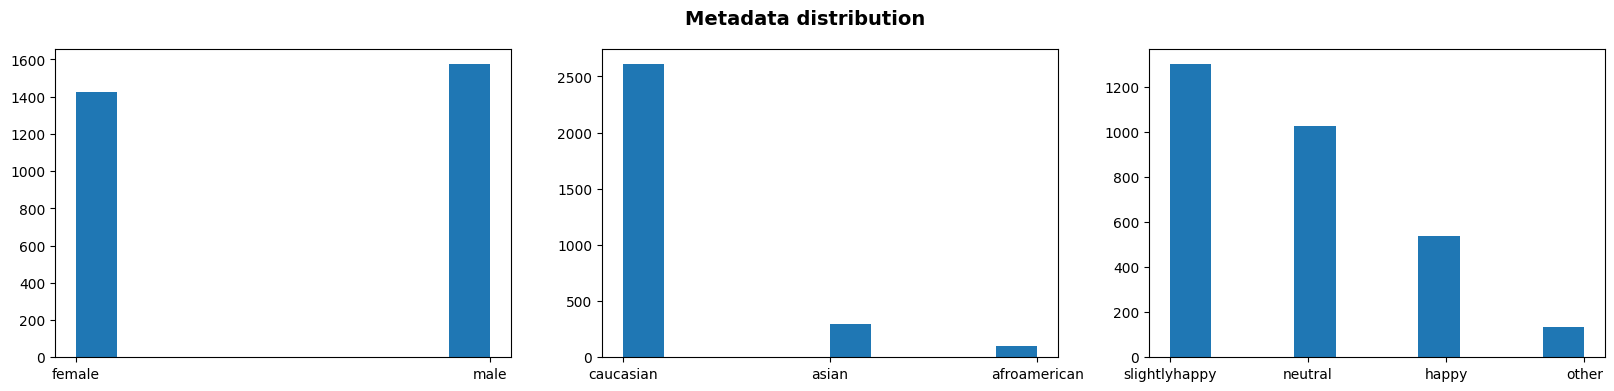

In [7]:
gender = []
ethnicity = []
emotion = []
for sample in M_train:
  gender.append(sample[0])
  ethnicity.append(sample[1])
  emotion.append(sample[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Metadata distribution', fontsize=14, fontweight='bold')

ax1.hist(gender)
ax2.hist(ethnicity)
ax3.hist(emotion)

# Preprocesando de los datos (imágenes de caras)
- Como veréis más adelante, definiremos nuestro modelo basado en ResNet50, que utiliza una regularización que cambia el rango de las imágenes de entrada. Por lo tanto, para alinearnos con la entrada ResNet50, preprocesaremos nuestras imágenes de entrada utilizando los valores promedios de RGB previamente calculados.


In [8]:
mean = np.array([[[[103.939, 116.779, 123.68]]]], dtype=np.float32)
X_train = X_train.astype(np.float32)-mean
X_valid = X_valid.astype(np.float32)-mean
X_test = X_test.astype(np.float32)-mean

# Descargando el modelo ResNet50 entrenado previamente
Usaremos ResNet50 entrenado previamente en el conjunto de datos Faces ([fuente](https://github.com/ox-vgg/vgg_face2)), beneficiándonos así de la transferencia de aprendizaje. Sin embargo, en este primer *notebook* ignoraremos los pesos preentrenados para entrenar nuestro modelo desde cero, como veréis más adelante.

In [9]:
from zipfile import ZipFile

# downloading the pretrained model
!wget https://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r1/model.zip

# decompressing the model
with ZipFile('model.zip','r') as zip:
   zip.extractall()
   print('Model decompressed successfully')

# removing the .zip file after extraction  to clean space
!rm model.zip

--2024-09-08 18:56:19--  https://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r1/model.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107893665 (103M) [application/zip]
Saving to: ‘model.zip’

model.zip           100%[===================>] 102.89M  14.4MB/s    in 21s     

2024-09-08 18:56:41 (4.87 MB/s) - ‘model.zip’ saved [107893665/107893665]

Model decompressed successfully


# Cargando el modelo pre-entrenado


In [10]:
#CODIGO ORIGINAL EN EL EJERCICIO QUE GENERA ERROR POR EL NOMBRE DE LAS CAPAS
import tensorflow as tf
import h5py

# loading the pretrained model
model = tf.keras.models.load_model('./model/weights.h5')

# printing the model (summary)
print(model.summary())


#CODIGO INTENTADO QUE FALLA - la solucion ha sido forzar la instalación de tensorflow versión 2.15
#from tensorflow.keras.models import load_model

# Cargar el modelo sin los nombres
#model = load_model('./model/weights.h5', compile=False)

# Imprimir el resumen del modelo
#print(model.summary())





Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 base_input (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1/7x7_s2 (Conv2D)       (None, 112, 112, 64)         9408      ['base_input[0][0]']          
                                                                                                  
 conv1/7x7_s2/bn (BatchNorm  (None, 112, 112, 64)         256       ['conv1/7x7_s2[0][0]']        
 alization)                                                                                       
                                                                                                  
 activation_1 (Activation)   (None, 112, 112, 64)         0         ['conv1/7x7_s2/bn[0][0]'

# Adaptando el modelo a nuestras necesidades
- A continuación, removeremos la última capa "classifier_low_dim" del modelo original e incluiremos en su lugar una serie de capas densas (totalmente conectadas) y una capa de *Dropout* (para prevenir el sobreajuste). Por último, añadiremos una capa densa que tendrá una activación sigmoid, responsable de predecir el valor de la edad. Llamaremos a estas capas recién agregadas **"cabeza de regresión"** (o *regression head*) porque queremos realizar una regresión de la edad aparente.
- Usando la instrucción **print(model.summary())**, podemos comparar el modelo original con nuestra versión modificada y observar los cambios en las últimas capas.


In [11]:
# Using the FC layer before the 'classifier_low_dim' layer as feature vector
fc_512 = model.get_layer('dim_proj').output

# adding a dropout layer to minimize overfiting problems
dp_layer = tf.keras.layers.Dropout(0.5)(fc_512)

# adding a few hidden FC layers to learn hidden representations
fc_128 = tf.keras.layers.Dense(128, activation='relu', name='f_128')(dp_layer)
fc_32 = tf.keras.layers.Dense(32, activation='relu', name='f_32')(fc_128)

# Includint an additional FC layer with sigmoid activation, used to regress
# the apparent age
output = tf.keras.layers.Dense(1, activation='sigmoid', name='predict')(fc_32)

# building and printing the final model
model = tf.keras.models.Model(inputs=model.get_layer('base_input').output, outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 base_input (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1/7x7_s2 (Conv2D)       (None, 112, 112, 64)         9408      ['base_input[0][0]']          
                                                                                                  
 conv1/7x7_s2/bn (BatchNorm  (None, 112, 112, 64)         256       ['conv1/7x7_s2[0][0]']        
 alization)                                                                                       
                                                                                                  
 activation_1 (Activation)   (None, 112, 112, 64)         0         ['conv1/7x7_s2/bn[0][0]'] 

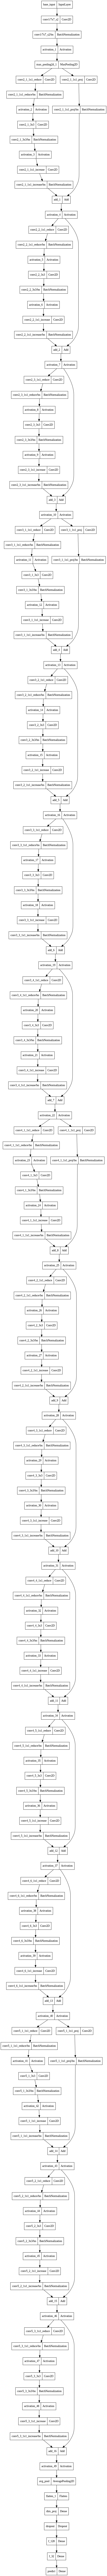

In [12]:
from keras.utils import plot_model

# visualizing the final model (as an image)
plot_model(model, to_file='model.png')

# **Montando nuestro Google Drive para guardar nuestros datos, modelos y resultados**
- Colab no conserva nuestros datos, modelos descargados, etc., cuando nos desconectamos (o cuando la sesión se cierra/termina). Si nos volvemos a conectar a Colab por algún motivo, veremos que estos datos se han perdido. Para evitar este problema, guardaremos todos los datos preprocesados, modelos y resultados en nuestra unidad de Google dentro de un directorio **"/M09-P01/"**. Aseguraos de haber creado esta carpeta en vuestro Google Drive.
- Consultad los **requisitos** en la parte superior de esta página en caso de que no tengáis suficiente espacio en vuestro Google Drive.



In [13]:
#--------------------------
MOUNT_GOOGLE_DRIVE = True
#--------------------------

if(MOUNT_GOOGLE_DRIVE==True):
  from google.colab import drive
  drive.mount('/content/gdrive')
  # Note, the default path will be: '/content/gdrive/MyDrive/'
  # In my case, the final path will be: '/content/gdrive/MyDrive/M09-P01/' as I
  # created a '/M09-P01/' folder in my google drive for this purpose.

Mounted at /content/gdrive


# Guardando los datos y el modelo en Google Drive

In [14]:
with open('/content/gdrive/MyDrive/M09-P01/train.npy', 'wb') as f:
  np.save(f, X_train)
  np.save(f, Y_train)
  np.save(f, M_train)
with open('/content/gdrive/MyDrive/M09-P01/valid.npy', 'wb') as f:
  np.save(f, X_valid)
  np.save(f, Y_valid)
  np.save(f, M_valid)
with open('/content/gdrive/MyDrive/M09-P01/test.npy', 'wb') as f:
  np.save(f, X_test)
  np.save(f, Y_test)
  np.save(f, M_test)

model.save('/content/gdrive/MyDrive/M09-P01/init_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
